# Определение возраста покупателей

Задача:

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Данные представляют собой набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импортируем необходимые библиотеки и загрузим данные

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,9)

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

Создадим генератор для загрузки изображений, сделаем масштабирование от 0 до 1

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Разделим данные на признаки и таргет

In [5]:
features, target = next(train_gen_flow)

In [6]:
features.shape

(32, 224, 224, 3)

Получилось 32 батча с 3-слойными изображениями 224 на 224 пикселя. В целом, 7600 изображений вполне достаточно для обучения, но при недостаточной точности можно добавить этап аугментации изображений, тем смым увеличив количество данных в обучающей выборке.

Построим гистограмму распределения возраста людей на фотографиях.

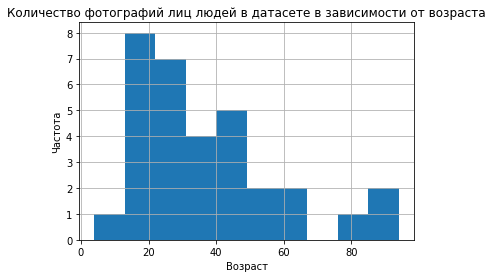

In [7]:
plt.hist(target)
plt.grid()
plt.title('Количество фотографий лиц людей в датасете в зависимости от возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

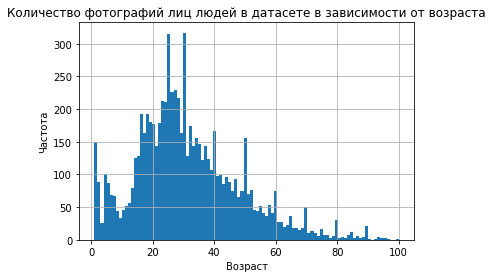

In [20]:
plt.hist(data['real_age'], bins=100)
plt.grid()
plt.title('Количество фотографий лиц людей в датасете в зависимости от возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

In [8]:
target.min()

4

In [9]:
target.max()

94

На фотографиях представлены преимущественно люди 15-30 лет, в гораздо меньшем количестве - пенсионеры и дети. В целом, размах возрастов 4-94 года, каких-либо очевидных выбросов по возрасту не наблюдается, распределение близко к нормальному, смещено в область малого возраста.

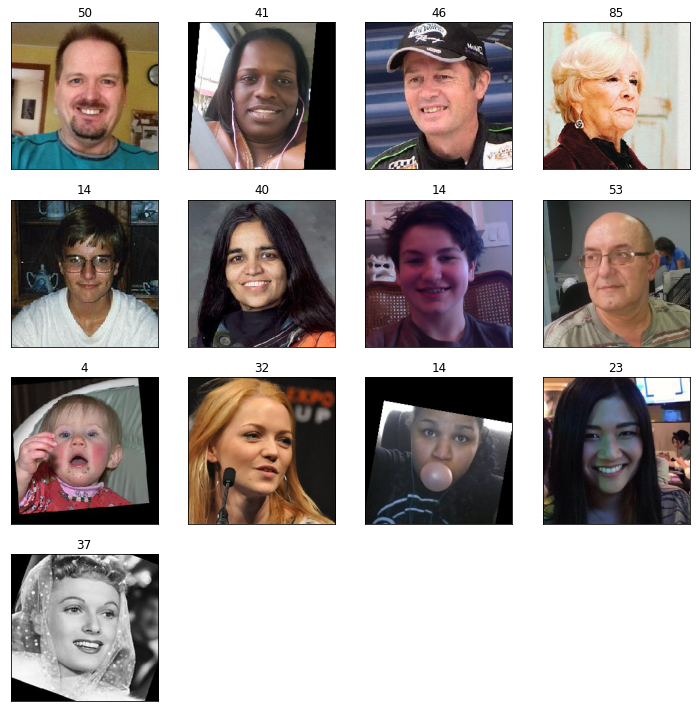

In [10]:
fig = plt.figure(figsize=(10,10))
for i in range(13):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

На фотографиях представлены лица людей разных возрастов, в разной цветовой гамме, качестве, с разным направлением взгляда и площадью, занимаемой лицом. На фото представлены только лица, часть фотографий представлена в анфас, часть в профиль. Фотографии могут быть повернуты, среди отобранных для анализа перевернутых фотографий нет. Помимо посторонних объектов на фотографиях каких-либо дефектов, искажающих лица, не наблюдается.

Итог: 
- На фотографиях из используемого для обучения датасета представлены преимущественно люди 15-30 лет, в гораздо меньшем количестве - пенсионеры и дети.
- Данные из датасета разнообразны по типам и ориентации лиц на фотографиях, каких-либо дефектов, искажающих лица, не наблюдается.

## Обучение модели

Используем модель ResNet50 без дополнительной аугментации фотографий с функцией активации ReLU, в качестве функции потерь - MSE, количество эпох - 7 

```python

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
optimizer = Adam(lr=0.0001)
 
def load_train(path):
    faces = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=faces,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_datagen_flow
 
def load_test(path):
    faces = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=faces,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_datagen_flow
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    classes=1,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False) 
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=7,
               steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/7
2023-09-04 08:29:06.661381: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-04 08:29:06.954423: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 51s - loss: 289.5876 - mae: 12.1755 - val_loss: 1120.6298 - val_mae: 28.9768
Epoch 2/7
178/178 - 42s - loss: 67.1084 - mae: 6.1981 - val_loss: 842.1612 - val_mae: 23.9650
Epoch 3/7
178/178 - 42s - loss: 29.8994 - mae: 4.2028 - val_loss: 259.4469 - val_mae: 12.0233
Epoch 4/7
178/178 - 42s - loss: 18.0117 - mae: 3.2868 - val_loss: 134.6190 - val_mae: 8.6265
Epoch 5/7
178/178 - 42s - loss: 14.1235 - mae: 2.9016 - val_loss: 81.0600 - val_mae: 6.9610
Epoch 6/7
178/178 - 42s - loss: 12.7904 - mae: 2.7489 - val_loss: 102.7216 - val_mae: 7.6976
Epoch 7/7
178/178 - 42s - loss: 11.9931 - mae: 2.6523 - val_loss: 67.3774 - val_mae: 6.2574
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 67.3774 - mae: 6.2574
Test MAE: 6.2574

```

Итог: В течение 7 эпох модель достигает MAE 6.2574 на валидационной выборке

## Анализ обученной модели

Использованная модель ResNet50 без дополнительной обработки фотографий (т.к. они уже были обработаны) из датасета в течение 5-7 эпох достигла MAE < 8, при этом количество фотографий для каждого возраста было не одинаковым, со значительным преобладанием данных в дипазоне 15-30 лет, что, тем-не-менее, не помешало модели обучиться 